<a href="https://colab.research.google.com/github/WanPgui/Companies_sector_research/blob/main/XGBoost_VS_Random_Forest_Comparison_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CONNECT COLAB TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/MyDrive/Mission_Capstone/


clustered_dataset.csv  Company_dataset.zip  extracted  kmeans_cluster_model.pkl


In [3]:
# Import required libraries and set paths
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Path to  Mission_capstone folder in Google Drive
path = "/content/drive/MyDrive/Mission_Capstone/"

# Re-mount Google Drive to ensure connection before reading files
from google.colab import drive
drive.mount('/content/drive')

# Load dataset with clusters (assigned previously)
df = pd.read_csv(path + "clustered_dataset.csv")

# Load saved KMeans model
kmeans = joblib.load(path + "kmeans_cluster_model.pkl")

print("Dataset shape:", df.shape)
print(df.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (7173426, 12)
Index(['name', 'domain', 'year_founded', 'industry', 'size_range', 'locality',
       'country', 'linkedin_url', 'current_employee_estimate',
       'total_employee_estimate', 'company_age', 'avg_size'],
      dtype='object')


In [4]:
# Assign clusters using the saved KMeans model
# Includes proper encoding and scaling of features exactly like the original model

from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Encode categorical variables
le_industry = LabelEncoder()
le_country = LabelEncoder()

# Fit and transform industry and country
df['industry_enc'] = le_industry.fit_transform(df['industry'])
df['country_enc'] = le_country.fit_transform(df['country'])

# Select the 6 features that the KMeans model expects
features_kmeans = [
    'industry_enc',
    'country_enc',
    'company_age',
    'avg_size',
    'current_employee_estimate',
    'total_employee_estimate'
]
X_final = df[features_kmeans]

# Scale features to match KMeans training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Predict clusters using the saved KMeans model
df['cluster'] = kmeans.predict(X_scaled)

# Display cluster distribution
print("Cluster distribution after assignment:")
print(df['cluster'].value_counts())



Cluster distribution after assignment:
cluster
3    1855344
1    1332567
0    1329098
2    1094473
5     629819
7     422067
6     377652
4     132406
Name: count, dtype: int64


In [5]:
# Absolute growth and growth rate
df['growth'] = df['total_employee_estimate'] - df['current_employee_estimate']
df['growth_rate'] = df['growth'] / df['current_employee_estimate']

# Binary growth category (Growing / Stable)
df['growth_category'] = df['growth'].apply(lambda x: "Growing" if x > 0 else "Stable")

# Assign Low / Moderate / High growth using quantiles for balanced categories
low_threshold = df['growth'].quantile(0.33)
high_threshold = df['growth'].quantile(0.66)

def assign_growth_level(x):
    if x < low_threshold:
        return "Low_Growth"
    elif x < high_threshold:
        return "Moderate_Growth"
    else:
        return "High_Growth"

df['growth_level'] = df['growth'].apply(assign_growth_level)

# Quick check of first rows and distribution
print(df[['growth','growth_category','growth_level','cluster']].head())
print("\nGrowth level counts:")
print(df['growth_level'].value_counts())



   growth growth_category growth_level  cluster
0  442859         Growing  High_Growth        4
1  150598         Growing  High_Growth        4
2  265079         Growing  High_Growth        4
3  283795         Growing  High_Growth        4
4  270597         Growing  High_Growth        4

Growth level counts:
growth_level
Moderate_Growth    4151684
High_Growth        3021742
Name: count, dtype: int64


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc

# Sample dataset to reduce memory usage
df_sample = df.sample(n=200000, random_state=42)

print("Sample shape:", df_sample.shape)

# Encode categorical variables using LabelEncoder (lighter than one-hot encoding)
le_industry = LabelEncoder()
le_country = LabelEncoder()
le_cluster = LabelEncoder()

df_sample['industry_enc'] = le_industry.fit_transform(df_sample['industry'])
df_sample['country_enc'] = le_country.fit_transform(df_sample['country'])
df_sample['cluster_enc'] = le_cluster.fit_transform(df_sample['cluster'])

# Select only necessary features for modeling
feature_columns = [
    'industry_enc',
    'country_enc',
    'company_age',
    'avg_size',
    'current_employee_estimate',
    'total_employee_estimate',
    'cluster_enc'
]

X = df_sample[feature_columns]

# Encode target variables
le_category = LabelEncoder()
y_category = le_category.fit_transform(df_sample['growth_category'])

le_level = LabelEncoder()
y_level = le_level.fit_transform(df_sample['growth_level'])

# Train-test split
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X, y_category,
    test_size=0.2,
    random_state=42,
    stratify=y_category
)

X_train_level, X_test_level, y_train_level, y_test_level = train_test_split(
    X, y_level,
    test_size=0.2,
    random_state=42,
    stratify=y_level
)

# Free memory
del df_sample
gc.collect()

print("Features and targets prepared successfully")



Sample shape: (200000, 19)
Features and targets prepared successfully


Accuracy: 0.9983

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16922
           1       1.00      1.00      1.00     23078

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



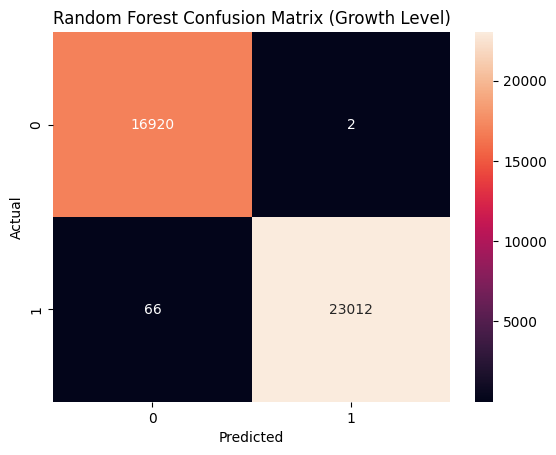

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest (growth_level target)
rf_level = RandomForestClassifier(
    n_estimators=50,        # reduced from 100 to prevent memory overload
    max_depth=15,           # control tree growth
    n_jobs=-1,              # use all CPU cores
    random_state=42
)

rf_level.fit(X_train_level, y_train_level)

# Predictions
y_pred_level = rf_level.predict(X_test_level)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test_level, y_pred_level))
print("\nClassification Report:\n")
print(classification_report(y_test_level, y_pred_level))

# Confusion Matrix
cm = confusion_matrix(y_test_level, y_pred_level)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix (Growth Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [8]:
!pip install xgboost


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize XGBoost (memory-safe configuration)
xgb_level = XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',     # much faster and memory efficient
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train model
xgb_level.fit(X_train_level, y_train_level)

# Predictions
y_pred_xgb_level = xgb_level.predict(X_test_level)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test_level, y_pred_xgb_level))
print("Precision:", precision_score(y_test_level, y_pred_xgb_level))
print("Recall:", recall_score(y_test_level, y_pred_xgb_level))
print("F1 Score:", f1_score(y_test_level, y_pred_xgb_level))

print("\nClassification Report:\n")
print(classification_report(y_test_level, y_pred_xgb_level))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:50:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9937
Precision: 0.9999561941475381
Recall: 0.9891238408874252
F1 Score: 0.9945105215004575

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16922
           1       1.00      0.99      0.99     23078

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



In [10]:
# Random Forest predictions (already trained earlier)
y_pred_rf_level = rf_level.predict(X_test_level)

print("Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test_level, y_pred_rf_level))
print("Precision:", precision_score(y_test_level, y_pred_rf_level))
print("Recall:", recall_score(y_test_level, y_pred_rf_level))
print("F1 Score:", f1_score(y_test_level, y_pred_rf_level))


Random Forest Metrics
Accuracy: 0.9983
Precision: 0.9999130963761189
Recall: 0.9971401334604385
F1 Score: 0.9985246897509329


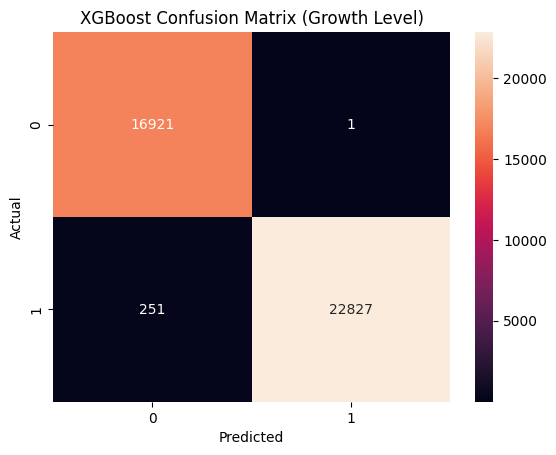

In [11]:
cm_xgb = confusion_matrix(y_test_level, y_pred_xgb_level)

plt.figure()
sns.heatmap(cm_xgb, annot=True, fmt='d')
plt.title("XGBoost Confusion Matrix (Growth Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


                     Feature  Importance
5    total_employee_estimate    0.706511
4  current_employee_estimate    0.223691
3                   avg_size    0.057078
2                company_age    0.005473
1                country_enc    0.003568
0               industry_enc    0.003104
6                cluster_enc    0.000574


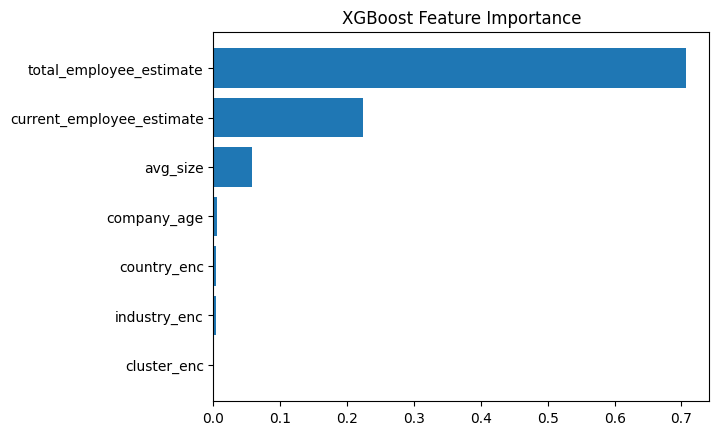

In [12]:
import pandas as pd

importance = pd.DataFrame({
    'Feature': X_train_level.columns,
    'Importance': xgb_level.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance)

plt.figure()
plt.barh(importance['Feature'], importance['Importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()


In [13]:
rf_category = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

rf_category.fit(X_train_cat, y_train_cat)

y_pred_rf_cat = rf_category.predict(X_test_cat)

print("Random Forest (Growth Category)")
print("Accuracy:", accuracy_score(y_test_cat, y_pred_rf_cat))
print("Precision:", precision_score(y_test_cat, y_pred_rf_cat))
print("Recall:", recall_score(y_test_cat, y_pred_rf_cat))
print("F1 Score:", f1_score(y_test_cat, y_pred_rf_cat))


Random Forest (Growth Category)
Accuracy: 0.9981
Precision: 1.0
Recall: 0.9943389199255122
F1 Score: 0.9971614252633152


In [14]:
xgb_category = XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_category.fit(X_train_cat, y_train_cat)

y_pred_xgb_cat = xgb_category.predict(X_test_cat)

print("XGBoost (Growth Category)")
print("Accuracy:", accuracy_score(y_test_cat, y_pred_xgb_cat))
print("Precision:", precision_score(y_test_cat, y_pred_xgb_cat))
print("Recall:", recall_score(y_test_cat, y_pred_xgb_cat))
print("F1 Score:", f1_score(y_test_cat, y_pred_xgb_cat))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:53:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (Growth Category)
Accuracy: 0.9957
Precision: 0.9999245567710298
Recall: 0.9872625698324022
F1 Score: 0.9935532233883059


In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Collect all predictions
results = []

# Growth Level - Random Forest
results.append([
    "Random Forest",
    "Growth Level",
    accuracy_score(y_test_level, y_pred_rf_level),
    precision_score(y_test_level, y_pred_rf_level),
    recall_score(y_test_level, y_pred_rf_level),
    f1_score(y_test_level, y_pred_rf_level)
])

# Growth Level - XGBoost
results.append([
    "XGBoost",
    "Growth Level",
    accuracy_score(y_test_level, y_pred_xgb_level),
    precision_score(y_test_level, y_pred_xgb_level),
    recall_score(y_test_level, y_pred_xgb_level),
    f1_score(y_test_level, y_pred_xgb_level)
])

# Growth Category - Random Forest
results.append([
    "Random Forest",
    "Growth Category",
    accuracy_score(y_test_cat, y_pred_rf_cat),
    precision_score(y_test_cat, y_pred_rf_cat),
    recall_score(y_test_cat, y_pred_rf_cat),
    f1_score(y_test_cat, y_pred_rf_cat)
])

# Growth Category - XGBoost
results.append([
    "XGBoost",
    "Growth Category",
    accuracy_score(y_test_cat, y_pred_xgb_cat),
    precision_score(y_test_cat, y_pred_xgb_cat),
    recall_score(y_test_cat, y_pred_xgb_cat),
    f1_score(y_test_cat, y_pred_xgb_cat)
])

metrics_table = pd.DataFrame(
    results,
    columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"]
)

print(metrics_table)


           Model           Target  Accuracy  Precision    Recall  F1 Score
0  Random Forest     Growth Level    0.9983   0.999913  0.997140  0.998525
1        XGBoost     Growth Level    0.9937   0.999956  0.989124  0.994511
2  Random Forest  Growth Category    0.9981   1.000000  0.994339  0.997161
3        XGBoost  Growth Category    0.9957   0.999925  0.987263  0.993553


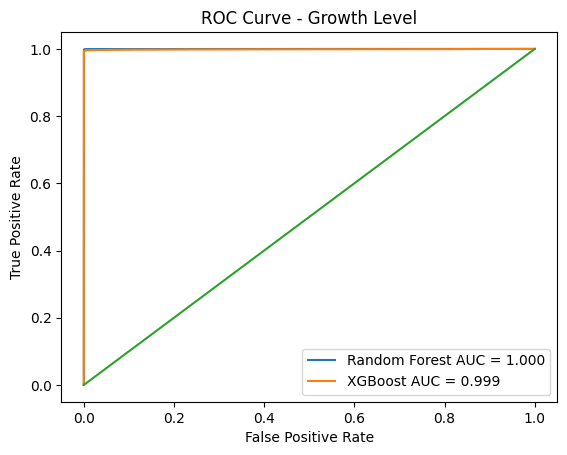

In [17]:
# Generate roc curves
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for Growth Level
rf_probs = rf_level.predict_proba(X_test_level)[:,1]
xgb_probs = xgb_level.predict_proba(X_test_level)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(y_test_level, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_level, xgb_probs)

rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure()
plt.plot(rf_fpr, rf_tpr, label="Random Forest AUC = %.3f" % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, label="XGBoost AUC = %.3f" % xgb_auc)
plt.plot([0,1],[0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Growth Level")
plt.legend()
plt.show()


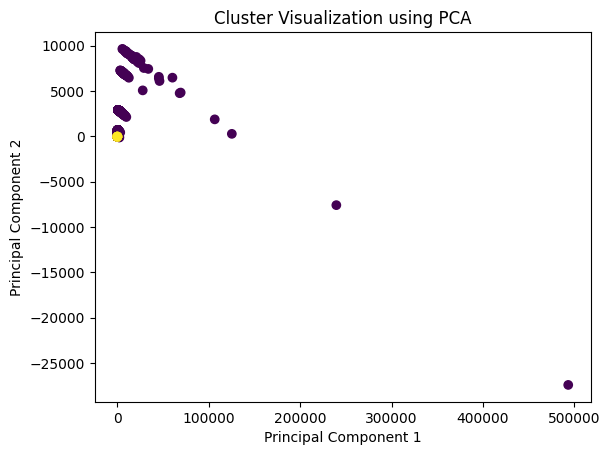

In [18]:
# Cluster visualization(PCA projection)
from sklearn.decomposition import PCA

# Reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_level)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train_level)
plt.title("Cluster Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [19]:
import pandas as pd
import joblib
import numpy as np

# 1. Save metrics comparison table
metrics_table.to_csv('model_comparison_metrics.csv', index=False)

# 2. Save XGBoost feature importance (growth level)
importance.to_csv('xgboost_feature_importance_growth_level.csv', index=False)

# 3. Save confusion matrices

cm_rf_level = confusion_matrix(y_test_level, y_pred_rf_level)
pd.DataFrame(cm_rf_level).to_csv('random_forest_confusion_matrix_growth_level.csv', index=False)

cm_xgb_level = confusion_matrix(y_test_level, y_pred_xgb_level)
pd.DataFrame(cm_xgb_level).to_csv('xgboost_confusion_matrix_growth_level.csv', index=False)

cm_rf_cat = confusion_matrix(y_test_cat, y_pred_rf_cat)
pd.DataFrame(cm_rf_cat).to_csv('random_forest_confusion_matrix_growth_category.csv', index=False)

cm_xgb_cat = confusion_matrix(y_test_cat, y_pred_xgb_cat)
pd.DataFrame(cm_xgb_cat).to_csv('xgboost_confusion_matrix_growth_category.csv', index=False)

# 4. Save trained models
joblib.dump(rf_level, 'random_forest_growth_level.pkl')
joblib.dump(xgb_level, 'xgboost_growth_level.pkl')
joblib.dump(rf_category, 'random_forest_growth_category.pkl')
joblib.dump(xgb_category, 'xgboost_growth_category.pkl')

print("All results and trained models saved successfully.")


All results and trained models saved successfully.


In [21]:
# Silhouette score and cluster validation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Use a smaller sample for validation to avoid memory issues
X_cluster_sample = X.sample(n=50000, random_state=42)[features_kmeans]

# Predict cluster labels for the sample
cluster_labels = kmeans.predict(X_cluster_sample)

# Silhouette Score
sil_score = silhouette_score(X_cluster_sample, cluster_labels)

# Davies-Bouldin Index (lower is better)
db_index = davies_bouldin_score(X_cluster_sample, cluster_labels)

# Calinski-Harabasz Score (higher is better)
ch_score = calinski_harabasz_score(X_cluster_sample, cluster_labels)

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", db_index)
print("Calinski-Harabasz Score:", ch_score)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


Silhouette Score: -0.043936086762134355
Davies-Bouldin Index: 1.506844059824579
Calinski-Harabasz Score: 75.82649346718773


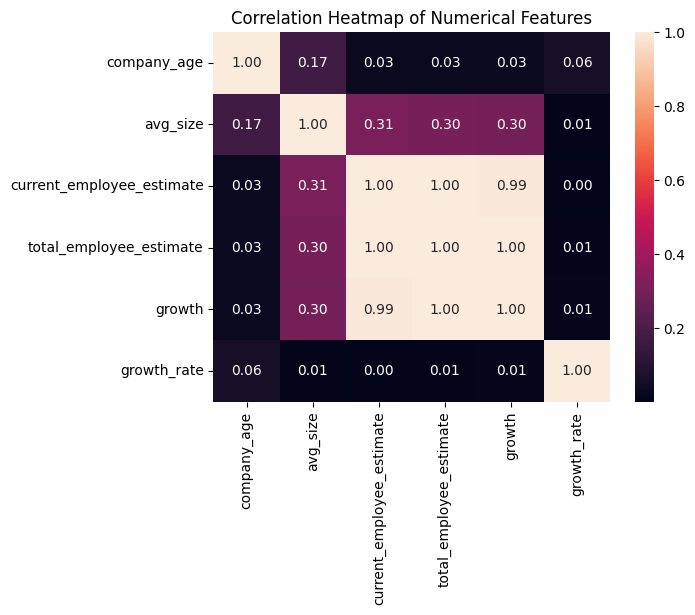

In [23]:
# Correlation heatmap analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Re-create df_sample for correlation heatmap to avoid NameError
df_sample_corr = df.sample(n=50000, random_state=42)

# Use only numerical features
numeric_features = [
    'company_age',
    'avg_size',
    'current_employee_estimate',
    'total_employee_estimate',
    'growth',
    'growth_rate'
]

corr_matrix = df_sample_corr[numeric_features].corr()

plt.figure()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [24]:
!pip install shap


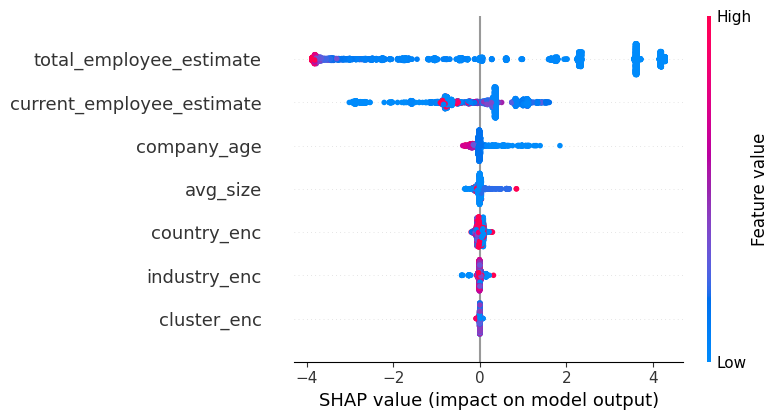

In [25]:
import shap

# Initialize explainer
explainer = shap.TreeExplainer(xgb_level)

# Use small sample for SHAP to avoid crash
X_shap_sample = X_test_level.sample(n=2000, random_state=42)

shap_values = explainer.shap_values(X_shap_sample)

# Summary plot
shap.summary_plot(shap_values, X_shap_sample)
